In [1]:
"""Notebook for validating SynthSeg in MONAI.
"""
import os
from pathlib import Path
import torch
import matplotlib.pyplot as plt
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureTyped,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    ScaleIntensityd,
)
from monai.data import (
    Dataset,
    DataLoader,
    decollate_batch,
)
from monai.metrics import DiceMetric
from monai.utils import set_determinism

import transforms_synthseg as transforms
import utils_synthseg as utils

set_determinism(seed=0)
torch.backends.cudnn.benchmark = True

In [2]:
# Settings
dir_input = "./training_label_maps"
dir_results = "./results"
spatial_size = None
patch_size = None
device = torch.device("cuda:0") 
model_pth = os.path.join(dir_results, 'model_best.pth')

In [3]:
labels = [str(d) for d in sorted(Path(dir_input).rglob('*.nii.gz'))]
val_files = [{"label": label_name} for label_name in labels]

print("len(val_files):", len(val_files))
print("val_files[0]=", val_files[0])

len(val_files): 20
val_files[0]= {'label': 'data/training_label_maps/training_seg_01.nii.gz'}


In [4]:
# Get test transforms and data loader
target_labels = list(transforms.MapLabelsSynthSeg.label_mapping().values())
val_transforms = Compose(
    [
        LoadImaged(keys="label"),
        EnsureChannelFirstd(keys="label"),
        Orientationd(keys="label", axcodes="RAS"),
        transforms.MapLabelsSynthSeg(),
        transforms.ResizeTransform(keys=["label"], spatial_size=spatial_size, method="pad_crop"),
        EnsureTyped(keys="label", dtype=torch.int16, device=device),            
        transforms.SynthSegd(params=utils.get_synth_params(target_labels, train=False)),
        ScaleIntensityd(keys="image"),                    
    ]
)

val_loader = DataLoader(
    Dataset(
        data=val_files,
        transform=val_transforms,
    ),
    batch_size=1,
    shuffle=False,
)

In [5]:
# Get model, etc
n_labels = len(target_labels)
print("n_labels =", n_labels)

out_channels = n_labels + 1
model = utils.get_model(out_channels)
model = model.to(device)

model_state_dict = torch.load(model_pth)
model_state_dict = {k.replace("module.", ""): v for k, v in model_state_dict.items()}
model.load_state_dict(model_state_dict)

post_pred = Compose([Activations(softmax=True), AsDiscrete(threshold=0.5)])
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
cmap, norm = utils.get_label_cmap(n_labels=out_channels)

n_labels = 31
BasicUNet features: (24, 48, 96, 192, 384, 24).
Model size: 12,729,416


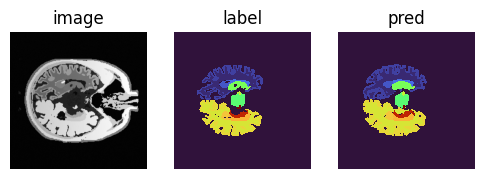

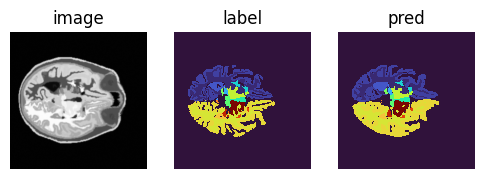

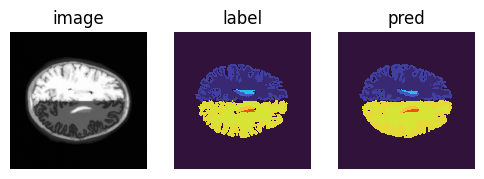

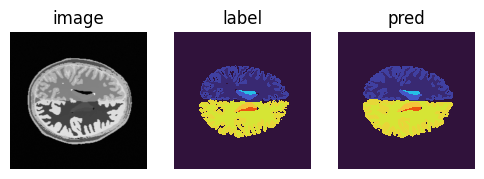

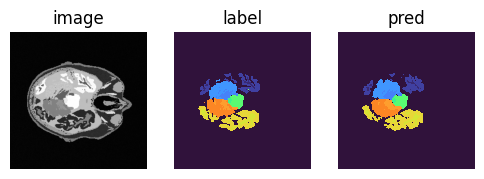

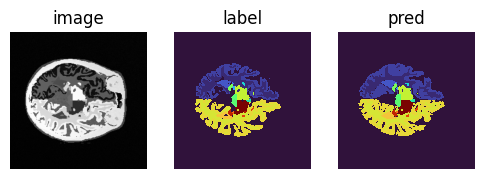

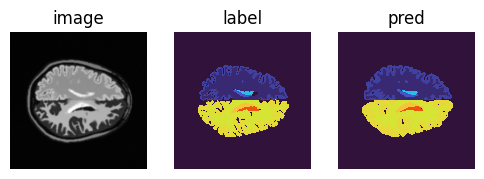

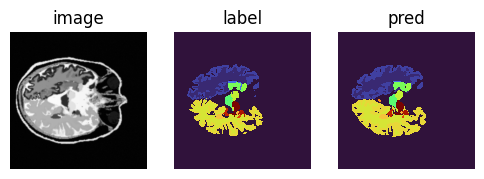

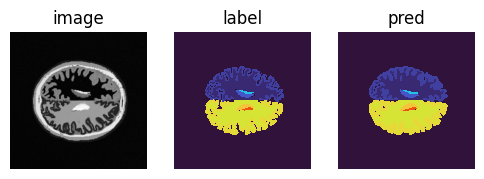

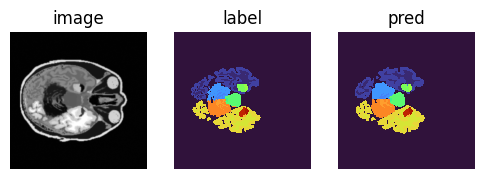

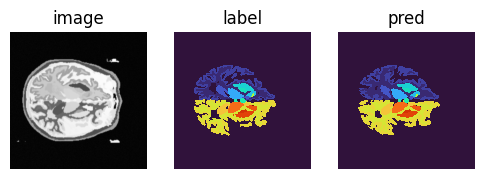

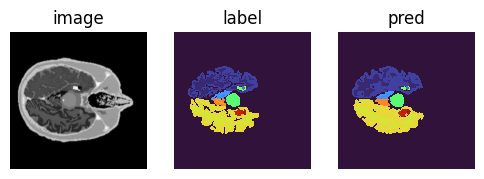

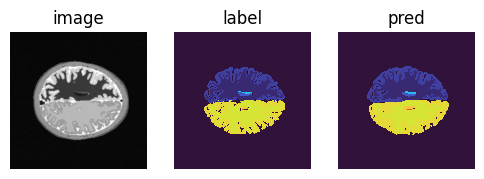

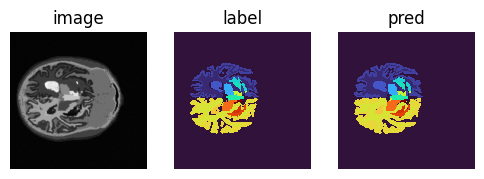

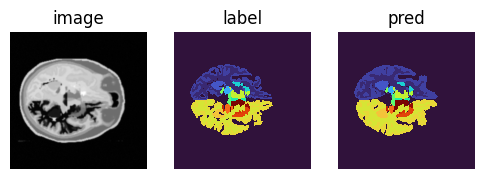

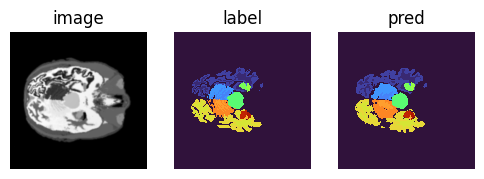

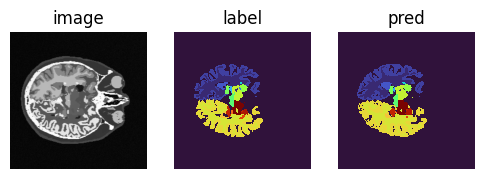

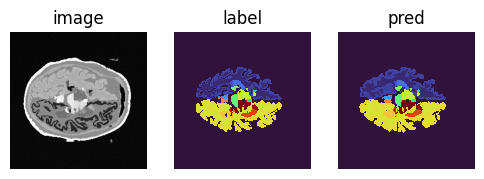

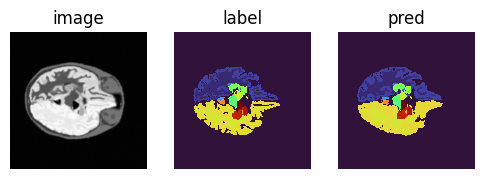

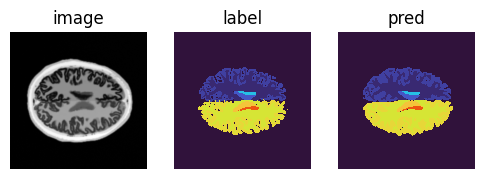

In [6]:
# Apply model to test data, showing predictions and calculating Dice scores
model.eval()
with torch.no_grad():
    for ix, batch_data in enumerate(val_loader):        
        image, label = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        pred = utils.inference(image, model, patch_size=patch_size)
        pred = [post_pred(i) for i in decollate_batch(pred)]

        dice_metric(y_pred=pred, y=label)
        dice_metric_batch(y_pred=pred, y=label)

        plt.figure("check", (6, 2))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.title("image")
        plt.imshow(utils.extract_slice(image[0][0]).cpu().numpy(), cmap="gray")
        plt.subplot(1, 3, 2)
        plt.axis('off')
        plt.title("label")
        plt.imshow(utils.extract_slice(label[0][0]).cpu().numpy(), cmap=cmap, norm=norm, interpolation="nearest")
        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.title("pred")
        plt.imshow(utils.extract_slice(pred[0].argmax(0)).cpu().numpy(), cmap=cmap, norm=norm, interpolation="nearest")
        plt.show()

    # aggregate the final mean dice result
    metric = dice_metric.aggregate().item()
    metric_batch = dice_metric_batch.aggregate()        
    # reset the status for next validation round
    dice_metric.reset()
    dice_metric_batch.reset()                     

Average Dice over all classes: 0.902


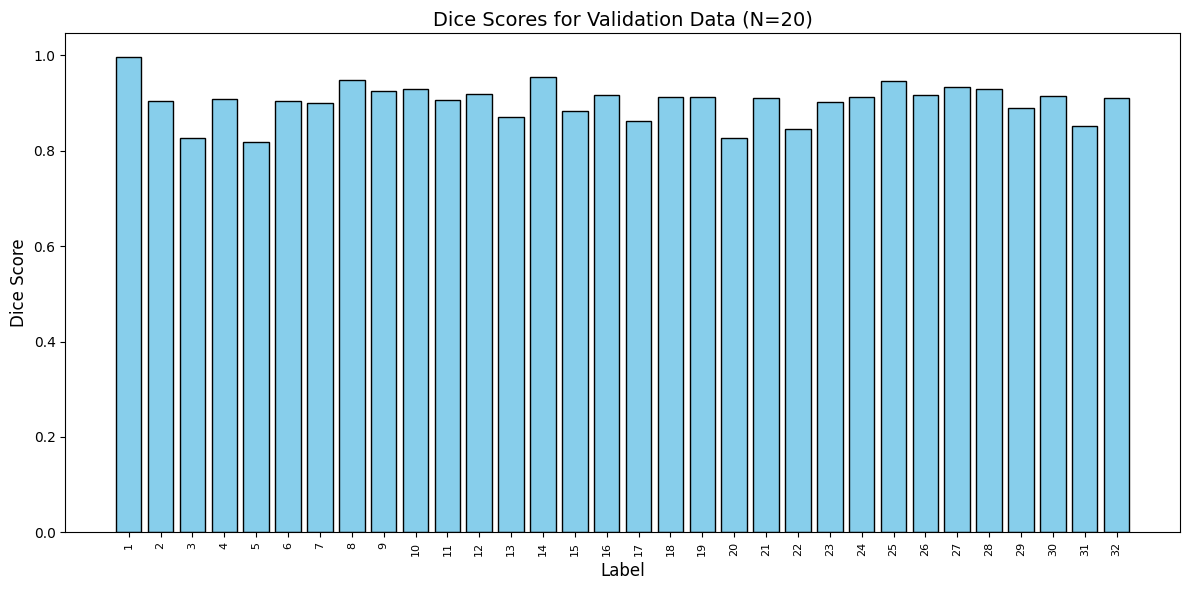

In [7]:
# Bar plot average validation labels Dice scores
dice_scores_np = metric_batch.cpu().numpy()
x_labels = [f"{i+1}" for i in range(len(dice_scores_np))]
print(f"Average Dice over all classes: {dice_scores_np.mean():.3f}")

plt.figure(figsize=(12, 6))
plt.bar(x_labels, dice_scores_np, color='skyblue', edgecolor='black')
plt.xlabel('Label', fontsize=12)
plt.ylabel('Dice Score', fontsize=12)
plt.title(f'Dice Scores for Validation Data (N={len(val_loader)})', fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.show()